# Import Packages

In [1]:
!pip install mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LayerNormalization
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

import sys

from scipy.stats import gaussian_kde as kde

import mat73

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

your_workspace = 'Ming/Public_Data' #<your_workspace>
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + <your_workspace>
import os
os.chdir(work_dir)
!pwd

In [64]:
################### Data mat ####################
'''
Experiment 1: Gaussian_steady_state_512.mat
Experiment 2: Exponential_transient_256.mat
Experiment 3: Gaussian_steady_state_3D.mat
Experiment 4: Channel_Binary_steady_state_128.mat
Experiment 5: Channel_Continuous_steady_state_128.mat
'''
experiment = 1
if experiment == 1:
  cov_type = 'Gaussian'
  pump_type = 'steady_state'
  ext = '512.mat'
elif experiment == 2:
  cov_type = 'Exponential'
  pump_type = 'transient'
  ext = '256.mat'
data = mat73.loadmat('./Data/'+'_'.join([cov_type,pump_type,ext]))


In [65]:
# principal components used as decoder
Z = data['Z'].T

# true latent random variables
alpha = data['rv'].T

# pumping wells idx
pump_well_id = np.arange(24, dtype=int)

# monitored heads in HT
Y_raw = data['y_save_monitored']
Y = np.zeros(Y_raw.shape)
Y = np.delete(Y,0,axis=1)

# remove the monitored value at pumpig well
for ii in range(Y.shape[-1]):
  Y[...,ii] = np.delete(Y_raw[...,ii],ii,axis=1)

if pump_type == 'transient':
  # select time steps to extract measurements
  select_time_steps = np.arange(2,11,2)
  Y = Y[:,:,select_time_steps,:]

# number of realizations/total samples
NR = Y.shape[0]
Y = Y.reshape([NR,-1])

(5000, 25, 25)
(5000, 24, 25)


In [66]:
# add noise to data
Y_noised = np.zeros_like(Y)
for i in range(Y.shape[0]):
  Y_noised[i]  = Y[i] + np.random.normal(0,np.abs(Y[i]*0.05),[1,Y[i].shape[0]])

# split data to train and test set
train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha[:train_test_cut], alpha[train_test_cut:]
Y_train, Y_test = Y_noised[:train_test_cut], Y_noised[train_test_cut:]

## PCA Decode

Text(0.5, 1.0, 'Inverse with PCA')

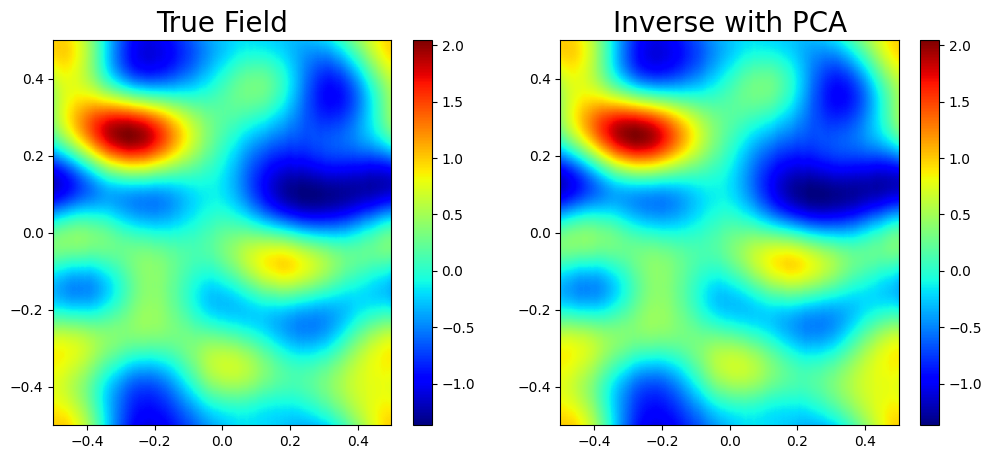

In [67]:
ss_train = np.matmul(alpha,Z)

############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = int(np.sqrt(Z.shape[1])), int(np.sqrt(Z.shape[1]))
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)
# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])

Xm, Ym = np.meshgrid(x,y)

fid = 9
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,np.reshape(np.matmul(alpha[fid],Z), (nx,ny),'F'), cmap='jet')
fig.colorbar(im, ax=ax)
ax.set_title('True Field',fontsize=20)


ax = axs[1]
im = ax.pcolormesh(Xm,Ym,ss_train[fid].reshape((nx,ny),order='F'), cmap='jet')
fig.colorbar(im, ax=ax)
ax.set_title('Inverse with PCA',fontsize=20)

In [69]:
#################  well network cell id ##################
well_id = np.arange(25)

# pump well matrix-wise index (index on x and y axis)
xloc = np.arange(int(nx/4),int(nx*3/4+1),int(nx/8))
yloc = np.arange(int(ny/4),int(ny*3/4+1),int(ny/8))

xloc = np.repeat(xloc,5)
yloc = np.tile(yloc,5)

# pump well index
pump_cell_idx = xloc + yloc*ny

## Define NN Model

Input: Heads (normalized)

Output: Latent variables (alpha)


In [71]:
hidden_act = None
hidden_dim = 3000
hidden_normal = LayerNormalization(axis=1) # BatchNormalization()
input = Input(shape = (Y_train.shape[-1],))
g = BatchNormalization()(input)

g = Dense(hidden_dim)(g)
g = LayerNormalization(axis=1)(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g_out = Dense(50)(g)
g_out = LayerNormalization(axis=1)(g_out)

G = Model(input, g_out, name = 'experiment_name')
G.summary()

alpha_loss_weight = np.ones((50,))

def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss

step = tf.Variable(0, trainable=False)
boundaries = [10000, 20000]
values = [1e-4, 1e-5, 1e-6]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)

# learning_rate = 0.0005
print(learning_rate)
G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

Model: "experiment_name"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization_15 (Bat  (None, 600)              2400      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 3000)              1803000   
                                                                 
 layer_normalization_11 (Lay  (None, 3000)             6000      
 erNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 3000)              0         
                                                                 
 dense_19 (Dense)            (None, 3000)          

## Train Model

In [72]:
batch_size = 1000

epochs = 50000
print_interval = 1000
for epoch in range(epochs):
  idx = np.random.randint(0, Y_train.shape[0], batch_size)
  to_train = Y_train[idx]
  expect_output = X_train[idx]

  loss = G.train_on_batch(to_train, expect_output)
  if epoch % print_interval == 0:
      print("[epoch %d], [the loss is %f]" % (epoch, loss))
  if loss < 1e-5:
    break

[epoch 0], [the loss is 2.011295]


KeyboardInterrupt: ignored

## Inverse on test data set

In [73]:
predictions = G.predict(Y_test)

pred_imgs = np.matmul(predictions,Z)

# reference data recovered with PCA decoder
true_imgs = np.matmul(X_test,Z)


16/16 [==============================] - 0s 3ms/step


In [74]:
acc_list = np.zeros((1,Y_test.shape[0]))
thres = 0.15

err_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  logK_true = true_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[0,check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))


Min Acc:  0.3313255310058594
Max Acc:  0.7991714477539062
Arg Max Acc:  357
Over 90%:  0
mean Acc:  0.5864489898681641
std Acc:  0.07215282427480034


357
0.1474888183457439
0.7329788208007812


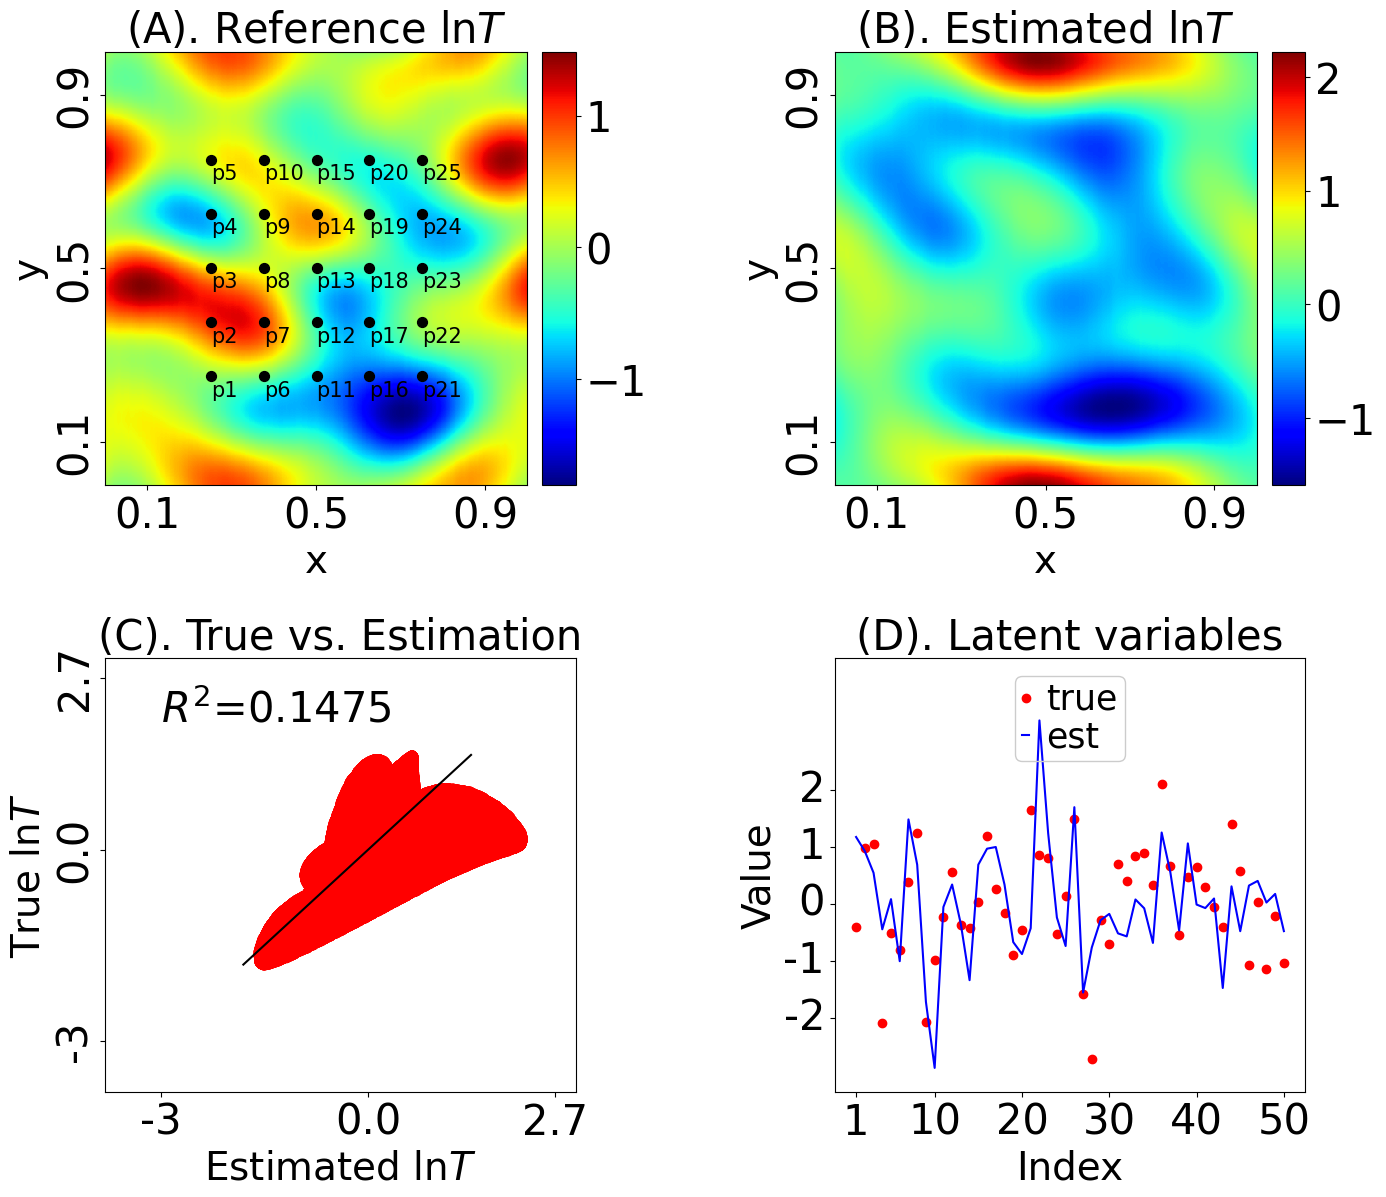

In [75]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
print(fid)
fid=105
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30
logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(2,2,figsize=(15,13), gridspec_kw={'width_ratios': [1, 1]})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.4)

axs = axs.flatten()
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)


cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

pump_id_list = np.arange(1,25)
shift = -256*10
for i in range(25):
  texts = 'p'+str(i+1)
  ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, c='k', fontsize=15, ha='left', va='top')
ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")


######################################
######################################
######################################
ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimated ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

######### compute r2 score of the regression: logK = inv_logK #########
logK_true_plot = logK_true.flatten()
logK_pred_plot = logK_pred.flatten()
var_model = np.sum((logK_pred_plot - logK_true_plot)**2)
var_data = np.sum((logK_true_plot-np.mean(logK_true_plot))**2)
r2_inverse_logK = (var_data-var_model) / var_data
print(r2_inverse_logK)

######### plot logK scatter: true vs. estimation #########
ax = axs[2]
min_logK_true_plot, max_logK_true_plot = min(logK_true_plot), max(logK_true_plot)
min_logK_pred_plot, max_logK_pred_plot = min(logK_pred_plot), max(logK_pred_plot)

ax.scatter(logK_pred_plot,logK_true_plot, label='logK',color='r')
ax.plot([min_logK_true_plot, max_logK_true_plot], [min_logK_true_plot, max_logK_true_plot],color='k')

ticks = [-3, 0.0, 2.7]
labels = [-3, 0.0, 2.7]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Estimated ln$T$',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-3.8, 3])
######### x-axis name, ticks and labels #########
ax.set_ylabel('True ln$T$',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-3.8, 3])

######### xfigure text #########
ax.text(-3.0, 2.0, '$R^2$=%.4f'%(r2_inverse_logK), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(C). True vs. Estimation', fontsize=title_size)


######################################
######################################
######################################
ax = axs[3]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')


xticks = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
xlabels = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='upper center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(D). Latent variables',fontsize=title_size)


# threshold 15%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))



# Uncertainty Quantification

In [76]:
n_noises = 20

Noised_Y_test = Y_test[fid] + np.random.normal(0,np.abs(Y_test[fid]*0.05),[n_noises,Y_test[fid].shape[0]])

uq_predictions = G.predict(Noised_Y_test)
std_predictions = np.std(uq_predictions,axis =0)

print(std_predictions.shape)
uq_pred_imgs = np.matmul(uq_predictions,Z)
var_up_pred_imgs = np.var(uq_pred_imgs.reshape((n_noises,nx,ny), order='F'),axis=0)
acc_list = np.zeros((n_noises,))
thres = 0.15

for check_id in range(n_noises):

  uq_logK_pred = uq_pred_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-uq_logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))



1/1 [==============================] - 0s 19ms/step
(50,)
Min Acc:  0.6856231689453125
Max Acc:  0.7565040588378906
Arg Max Acc:  12
Over 90%:  0
mean Acc:  0.7325252532958985
std Acc:  0.017486138941770066
